Реализовать с помощью Numpy класс MyMLP, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен

Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется.
Обеспечивать выбор следующих функции активации в рамках каждого слоя: ReLU, sigmoid, linear.
Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
Поддерживать использование l1, l2 и l1l2 регуляризаций.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [ ]:
class MyMLP:
    def __init__(self, layer_sizes, activations, task_type="regression", l1=0.0, l2=0.0, l1l2=0.0):
        if len(layer_sizes) < 2:
            raise ValueError("layer_sizes must contain at least input and output sizes (e.g., [input_dim, output_dim])")
        if len(activations) != len(layer_sizes) - 1:
            raise ValueError(f"Number of activations ({len(activations)}) must be equal to len(layer_sizes) - 1 = {len(layer_sizes) - 1}")
        if any(reg < 0 for reg in [l1, l2, l1l2]):
            raise ValueError("Regularization coefficients must be >= 0")
        valid_activations = ["relu", "sigmoid", "linear", "softmax"]
        for act in activations:
            if act not in valid_activations:
                raise ValueError(f"Unknown activation: {act}. Valid options: {valid_activations}")

        self.layer_sizes = layer_sizes
        self.activations = [a.lower() for a in activations]
        self.task_type = task_type
        self.weights = []
        self.biases = []
        self.l1 = l1
        self.l2 = l2
        self.l1l2 = l1l2

        for i in range(len(layer_sizes) - 1):
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i+1]))
            w = np.random.uniform(-limit, limit, (layer_sizes[i+1], layer_sizes[i]))
            b = np.zeros((layer_sizes[i+1], 1))
            self.weights.append(w)
            self.biases.append(b)

        if self.task_type == "classification":
            if activations[-1] not in ["sigmoid", "softmax"]:
                raise ValueError("For classification, last activation must be 'sigmoid' (binary) or 'softmax' (multiclass)")

    def _activation(self, x, activation):
        if activation == "relu":
            return np.maximum(0, x)
        elif activation == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif activation == "linear":
            return x
        elif activation == "softmax":
            exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
            return exp_x / np.sum(exp_x, axis=0, keepdims=True)
        else:
            raise ValueError(f"Unknown activation: {activation}")

    def _activation_derivative(self, x, activation):
        if activation == "relu":
            return (x > 0).astype(float)
        elif activation == "sigmoid":
            s = self._activation(x, "sigmoid")
            return s * (1 - s)
        elif activation == "linear":
            return np.ones_like(x)
        elif activation == "softmax":
            return 1

    def forward(self, input):
        if input.ndim != 2:
            raise ValueError("Input must be 2D array of shape (batch_size, features)")
        if input.shape[1] != self.layer_sizes[0]:
            raise ValueError(f"Input features ({input.shape[1]}) must match first layer size ({self.layer_sizes[0]})")

        current_values = input.T
        self.cache = [{"pre_activation": None, "post_activation": current_values}]
        for i in range(len(self.weights)):
            w = self.weights[i]
            b = self.biases[i]
            a = self.activations[i]
            output = np.dot(w, current_values) + b
            activated_output = self._activation(output, a)
            self.cache.append({"pre_activation": output, "post_activation": activated_output})
            current_values = activated_output
        return current_values.T

    def _compute_loss(self, y_true, y_pred):
        if y_true.shape != y_pred.shape:
            raise ValueError(f"Shapes of y_true {y_true.shape} and y_pred {y_pred.shape} don't match")
        if self.task_type == "classification":
            if self.activations[-1] == "softmax":
                loss = -np.mean(y_true * np.log(y_pred + 1e-15))  # CCE
            else:
                loss = -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))  # BCE
        else:
            loss = np.mean((y_true - y_pred) ** 2)  # MSE
        reg_loss = 0.0
        for w in self.weights:
            if self.l1 > 0:
                reg_loss += self.l1 * np.sum(np.abs(w))
            if self.l2 > 0:
                reg_loss += self.l2 * np.sum(w ** 2)
            if self.l1l2 > 0:
                reg_loss += self.l1l2 * (np.sum(np.abs(w)) + np.sum(w ** 2))

        return loss + reg_loss

    def backward(self, input, y_true, learning_rate):
        size = input.shape[0]
        y_pred = self.cache[-1]["post_activation"].T

        if self.task_type == "regression":
            d_a = 2 * (y_pred - y_true) / size
            d_output = d_a.T
        elif self.task_type == "classification":
            d_output = (y_pred - y_true).T

        for i in range(len(self.weights) - 1, -1, -1):
            d_w = np.dot(d_output, self.cache[i]["post_activation"].T) / size
            d_b = np.sum(d_output, axis=1, keepdims=True) / size

            if self.l1 > 0:
                d_w += self.l1 * np.sign(self.weights[i])
            if self.l2 > 0:
                d_w += 2 * self.l2 * self.weights[i]
            if self.l1l2 > 0:
                d_w += self.l1l2 * (np.sign(self.weights[i]) + 2 * self.weights[i])

            self.weights[i] -= learning_rate * d_w
            self.biases[i] -= learning_rate * d_b

            if i > 0:
                d_a = np.dot(self.weights[i].T, d_output)
                d_output = d_a * self._activation_derivative(self.cache[i]["pre_activation"], self.activations[i-1])

    def predict(self, x):
        raw_output = self.forward(x)
        if self.task_type == "classification":
            if self.activations[-1] == "sigmoid":
                return (raw_output > 0.5).astype(int)
            else:
                return np.argmax(raw_output, axis=1)
        else:
            return raw_output

    def fit(self, x, y, epochs=100, batch_size=32, learning_rate=0.01, verbose=True, validation_data=None):
        losses = []
        val_losses = []
        for epoch in range(epochs):
            indices = np.random.permutation(len(x))
            x_shuffled = x[indices]
            y_shuffled = y[indices]
            epoch_loss, num_batches = 0, 0
            for i in range(0, x.shape[0], batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                self.forward(x_batch)
                self.backward(x_batch, y_batch, learning_rate)
                y_pred = self.forward(x_batch)
                batch_loss = self._compute_loss(y_batch, y_pred)
                epoch_loss += batch_loss
                num_batches += 1
            epoch_loss /= num_batches
            losses.append(epoch_loss)

            if validation_data is not None:
                x_val, y_val = validation_data
                y_val_pred = self.forward(x_val)
                val_loss = self._compute_loss(y_val, y_val_pred)
                val_losses.append(val_loss)
                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
            elif verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}")

        plt.figure(figsize=(10, 6))
        plt.plot(losses, label="Train Loss")
        if validation_data is not None:
            plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Progress")
        plt.legend()
        plt.show()

        return self

Тесты с синтетическими данными

=== Регрессия без регуляризации ===
Epoch 0, Train Loss: 4079.6568
Epoch 10, Train Loss: 68.4695
Epoch 20, Train Loss: 48.5075
Epoch 30, Train Loss: 25.6625
Epoch 40, Train Loss: 8.7179


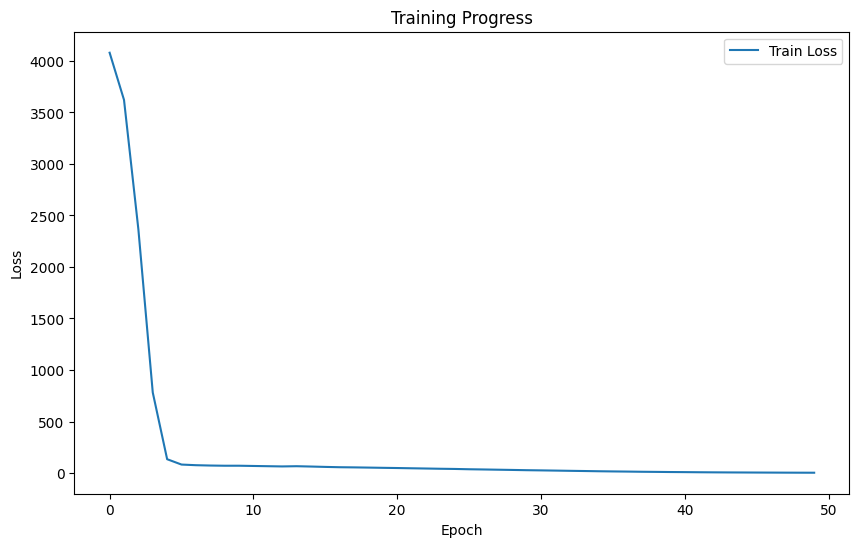

Train Loss (MSE): 2.8297433208801372


In [ ]:
#Регрессия без регуляризации
print("=== Регрессия без регуляризации ===")
X_reg, y_reg = make_regression(n_samples=1000, n_features=5, noise=0.1, random_state=42)
y_reg = y_reg.reshape(-1, 1)

model_reg = MyMLP([5, 10, 1], ["relu", "linear"], task_type="regression")
model_reg.fit(X_reg, y_reg, epochs=50, batch_size=32, learning_rate=0.01)

train_pred = model_reg.forward(X_reg)
train_loss = model_reg._compute_loss(y_reg, train_pred)
print("Train Loss (MSE):", train_loss)




=== Регрессия с L2 регуляризацией ===
Epoch 0, Train Loss: 4127.0719
Epoch 10, Train Loss: 69.1424
Epoch 20, Train Loss: 48.9686
Epoch 30, Train Loss: 23.9462
Epoch 40, Train Loss: 9.5168


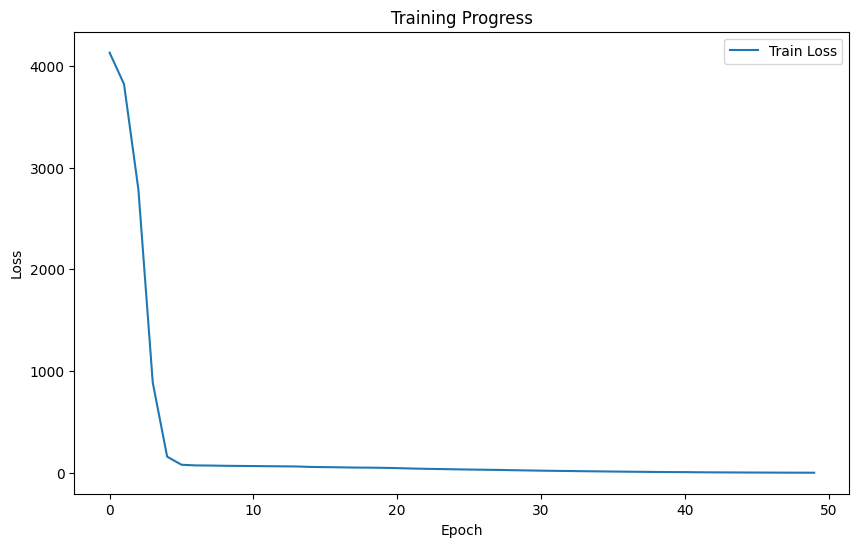

Train Loss с L2: 3.6058094315889684


In [ ]:
#Регрессия с L2 регуляризацией
print("\n=== Регрессия с L2 регуляризацией ===")
model_reg_l2 = MyMLP([5, 10, 1], ["relu", "linear"], task_type="regression", l2=0.001)
model_reg_l2.fit(X_reg, y_reg, epochs=50, batch_size=32, learning_rate=0.01)

train_pred_l2 = model_reg_l2.forward(X_reg)
train_loss_l2 = model_reg_l2._compute_loss(y_reg, train_pred_l2)
print("Train Loss с L2:", train_loss_l2)

In [ ]:
print("Min/Max y_reg:", y_reg.min(), y_reg.max())
print("Std y_reg:", y_reg.std())


Min/Max y_reg: -223.0834366815274 173.1379589811568
Std y_reg: 64.68990906580557



=== Бинарная классификация ===
Epoch 0, Train Loss: 0.7652
Epoch 10, Train Loss: 0.4023
Epoch 20, Train Loss: 0.3435
Epoch 30, Train Loss: 0.3271
Epoch 40, Train Loss: 0.3235


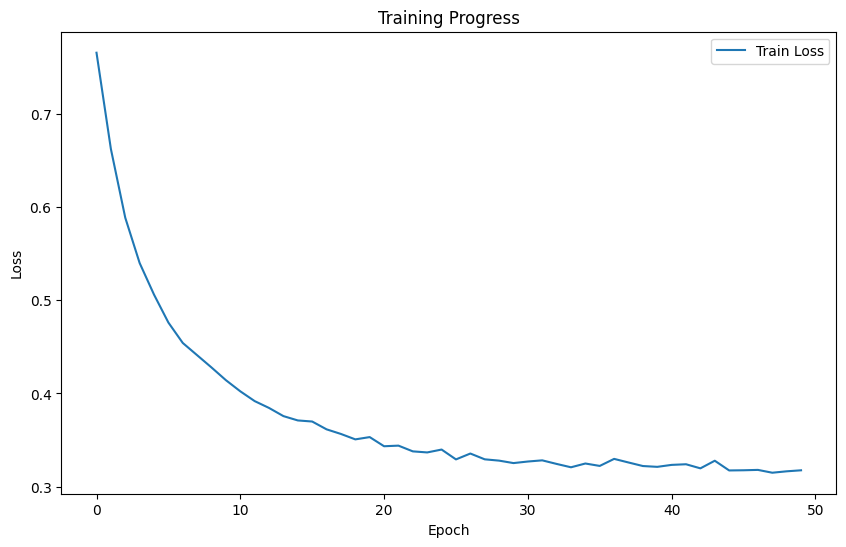

Train Loss (Binary Cross-Entropy): 0.3211232019781294
Predictions shape: (1000, 1)


In [ ]:
#Бинарная классификация
print("\n=== Бинарная классификация ===")
X_clf, y_clf = make_classification(n_samples=1000, n_features=5, n_classes=2, random_state=42)
y_clf = y_clf.reshape(-1, 1)

model_clf = MyMLP([5, 10, 1], ["relu", "sigmoid"], task_type="classification")
model_clf.fit(X_clf, y_clf, epochs=50, batch_size=32, learning_rate=0.01)

train_pred_clf = model_clf.predict(X_clf)
train_loss_clf = model_clf._compute_loss(y_clf, model_clf.forward(X_clf))
print("Train Loss (Binary Cross-Entropy):", train_loss_clf)
print("Predictions shape:", train_pred_clf.shape)


=== Классификация с L1 регуляризацией ===
Epoch 0, Train Loss: 0.7327
Epoch 10, Train Loss: 0.3972
Epoch 20, Train Loss: 0.3625
Epoch 30, Train Loss: 0.3497
Epoch 40, Train Loss: 0.3466


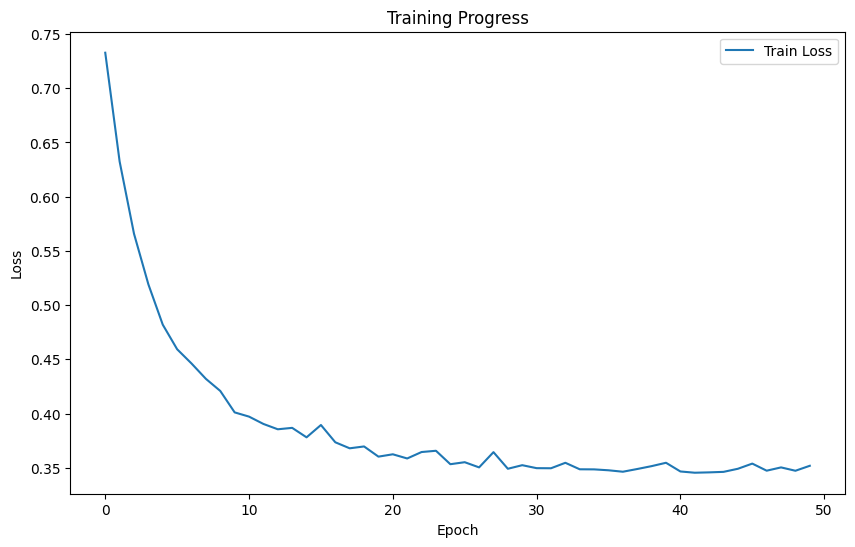

Train Loss с L1: 0.34889969883955424


In [ ]:
#Классификация с L1 регуляризацией
print("\n=== Классификация с L1 регуляризацией ===")
model_clf_l1 = MyMLP([5, 10, 1], ["relu", "sigmoid"], task_type="classification", l1=0.001)
model_clf_l1.fit(X_clf, y_clf, epochs=50, batch_size=32, learning_rate=0.01)

train_pred_clf_l1 = model_clf_l1.predict(X_clf)
train_loss_clf_l1 = model_clf_l1._compute_loss(y_clf, model_clf_l1.forward(X_clf))
print("Train Loss с L1:", train_loss_clf_l1)


Epoch 0, Train Loss: 4066.1256
Epoch 10, Train Loss: 63.4107
Epoch 20, Train Loss: 43.8683
Epoch 30, Train Loss: 21.1618
Epoch 40, Train Loss: 7.3908


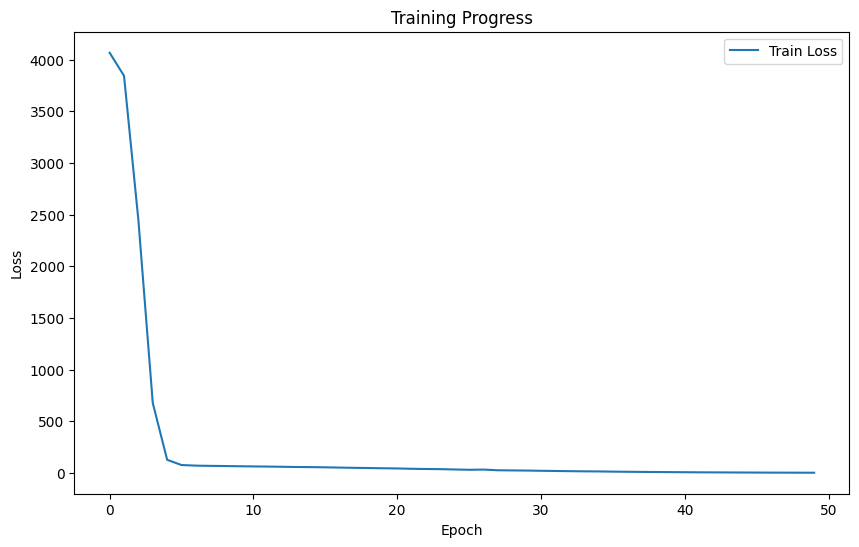

Train Loss с L1L2: 2.5151655425682304


In [ ]:
#Комбинированная регуляризация L1L2
model_combo = MyMLP([5, 10, 1], ["relu", "linear"], task_type="regression", l1l2=0.00005)
model_combo.fit(X_reg, y_reg, epochs=50, batch_size=32, learning_rate=0.01)

train_pred_combo = model_combo.forward(X_reg)
train_loss_combo = model_combo._compute_loss(y_reg, train_pred_combo)
print("Train Loss с L1L2:", train_loss_combo)